In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df_2022 = pd.read_csv('드라마영화예능_전처리데이터/22예능_전처리.csv', encoding='utf-8')
df_2023 = pd.read_csv('드라마영화예능_전처리데이터/23예능_전처리.csv', encoding='utf-8')
df_2024 = pd.read_csv('드라마영화예능_전처리데이터/24예능_전처리.csv', encoding='utf-8')

In [3]:
combined_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)
combined_df.shape

(1709, 7)

## 1. 예능 프로그램명이 들어있는 행만 살리기

In [4]:
df = [df_2022, df_2023, df_2024]

In [5]:
# 텍스트 파일 읽기
def load_inwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        inwords_list = file.read().splitlines()
    return inwords_list

# 파일에서 예능 프로그램 목록 로드
inwords_file_path = '../programs.txt'
file_inwords = load_inwords(inwords_file_path)

# 리스트 중복 삭제
all_inwords = list(set(file_inwords))

In [6]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

In [7]:
## df_2022

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list_2022 = []

for column in ['preprocessed_body']:
    word_counts = explode_and_count(df_2022, column)
    word_counts_list_2022.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body_2022 = pd.concat(word_counts_list_2022).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body_2022 = all_words_body_2022[all_words_body_2022['word'].str.len() > 1]

# all_inwords 리스트에 있는 단어들만 필터링
all_words_body_2022 = all_words_body_2022[all_words_body_2022['word'].isin(all_inwords)]

# 상위 10개 단어 출력
top_10_words_2022 = all_words_body_2022.head(10)
top_10_words_2022

,word,count
15151,연애,1190
775,게임,720
12603,스타,689
7438,무대,600
11916,솔로,493
3859,노래,450
26505,환승,244
5634,라디오,208
13002,시점,192
113,가요,182


In [8]:
## df_2023

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list_2023 = []

for column in ['preprocessed_body']:
    word_counts = explode_and_count(df_2023, column)
    word_counts_list_2023.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body_2023 = pd.concat(word_counts_list_2023).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body_2023 = all_words_body_2023[all_words_body_2023['word'].str.len() > 1]

# all_inwords 리스트에 있는 단어들만 필터링
all_words_body_2023 = all_words_body_2023[all_words_body_2023['word'].isin(all_inwords)]

# 상위 10개 단어 출력
top_10_words_2023 = all_words_body_2023.head(10)
top_10_words_2023

,word,count
9736,연애,512
522,게임,319
8117,스타,306
7695,솔로,267
9191,야구,180
2557,노래,176
17119,환승,174
16163,피지컬,136
13391,지구,135
14193,최강,127


In [9]:
## df_2024

# 각 칼럼에 대해 단어 빈도 계산
word_counts_list_2024 = []

for column in ['preprocessed_body']:
    word_counts = explode_and_count(df_2024, column)
    word_counts_list_2024.append(word_counts)

# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body_2024 = pd.concat(word_counts_list_2024).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body_2024 = all_words_body_2024[all_words_body_2024['word'].str.len() > 1]

# all_inwords 리스트에 있는 단어들만 필터링
all_words_body_2024 = all_words_body_2024[all_words_body_2024['word'].isin(all_inwords)]

# 상위 10개 단어 출력
top_10_words_2024 = all_words_body_2024.head(10)
top_10_words_2024

,word,count
9850,연애,510
548,게임,269
8206,스타,241
7766,솔로,223
2349,남매,197
9312,야구,189
4790,무대,165
17128,환승,157
2529,노래,150
14257,최강,141


## 4. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [10]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### df_2022

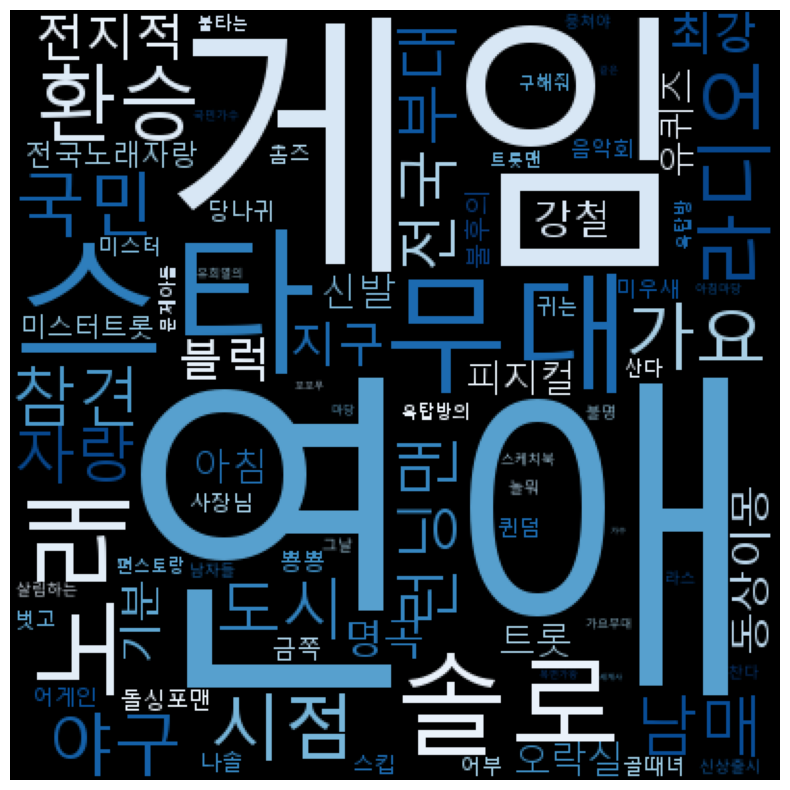

In [11]:
dic_word = all_words_body_2022.set_index('word').to_dict()['count']
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBu': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기
## plt.savefig('동감_워드클라우드') # 파일 저장

### df_2023

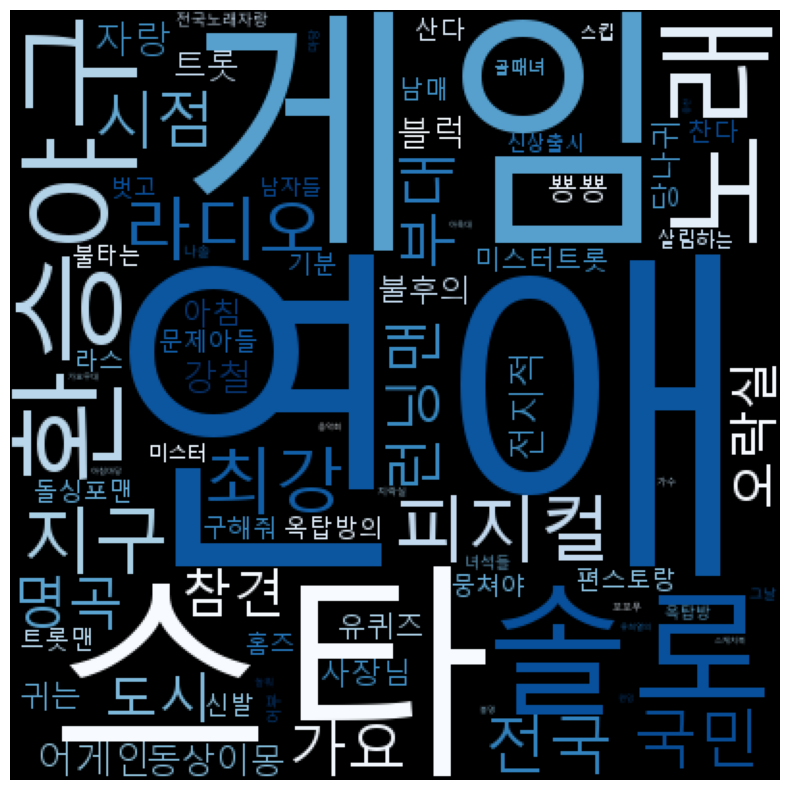

In [12]:
dic_word = all_words_body_2023.set_index('word').to_dict()['count']
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기
## plt.savefig('동감_워드클라우드') # 파일 저장

### df_2024

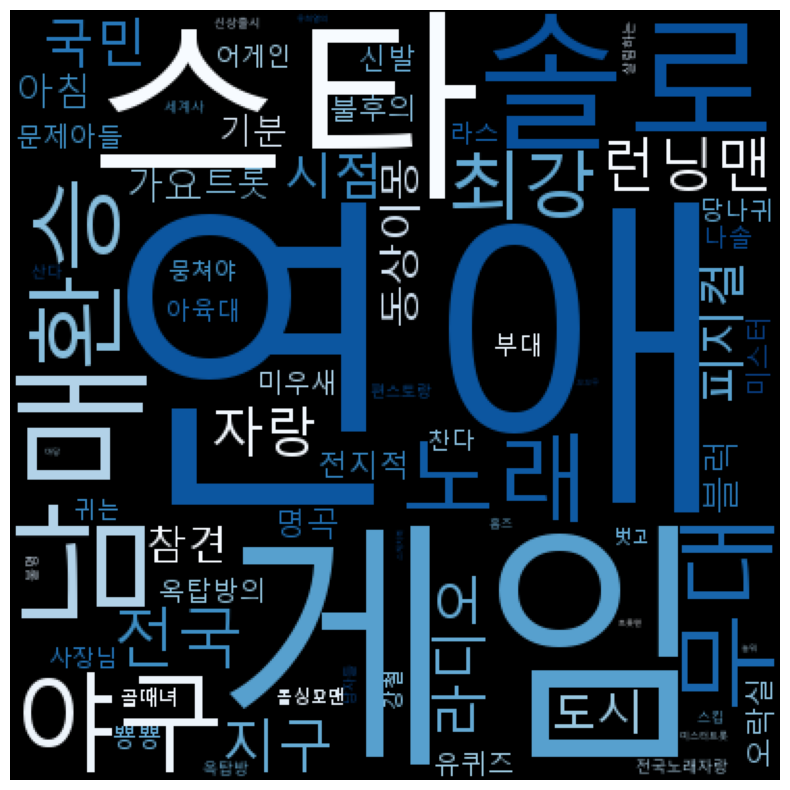

In [13]:
dic_word = all_words_body_2024.set_index('word').to_dict()['count']
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기
## plt.savefig('동감_워드클라우드') # 파일 저장